# Walker Example

In [1]:
import sys
sys.path.append('lib')

import numpy as np
import matplotlib.pyplot as plt
import os, time

from IPython.core import display

import pybullet as p
import pybullet_data
from utils import *
from scipy.optimize import fmin_bfgs
from costs_pseudo import *
from robot import *
from functools import partial

# import tensorflow as tf
# import tensorflow.compat.v1 as tf1
# import tf_robot_learning as rl
# import tf_robot_learning.distributions as ds
# from tf_robot_learning import kinematic as tk


DATA_PATH = '/home/teguh/git/publications/learning_distribution_gan/tf_robot_learning/data'

%load_ext autoreload
%autoreload 2
%matplotlib inline

### Setup Pybullet

In [2]:
physics_client_id = p.connect(p.GUI)

p.setPhysicsEngineParameter(enableFileCaching=0)
p.setAdditionalSearchPath(pybullet_data.getDataPath())
p.configureDebugVisualizer(p.COV_ENABLE_GUI,0)

In [3]:
p.resetSimulation()

#### Load in pybullet

In [4]:
#load robot
robot_urdf = DATA_PATH + '/urdf/walker_description/urdf/walker.urdf';
robot_id = p.loadURDF(fileName=robot_urdf, flags=p.URDF_USE_INERTIA_FROM_FILE)
dof = p.getNumJoints(robot_id)

In [5]:
#load plane
plane_id = p.loadURDF('plane.urdf')
p.resetBasePositionAndOrientation(plane_id, (0,0,0), np.array([0,0,0,1]))

In [6]:
p.resetBasePositionAndOrientation(robot_id, (0,0,1.14), np.array([0,0,0,1]))

#### Load obstacles

In [7]:
shelf_urdf = '/home/teguh/git/publications/learning_distribution_gan/tf_robot_learning/data/urdf/shelf_new.urdf'

shelf_id = p.loadURDF(shelf_urdf)

In [8]:
p.resetBasePositionAndOrientation(shelf_id,(.7,-0.75,0), (0,0,np.sin(np.pi/2), np.cos(np.pi/2)) )

In [9]:
p.resetJointState(shelf_id, 7, 0.4)

In [10]:
joint_angles = np.arange(0, np.pi/2, np.pi/200)*(-1)
joint_angles = np.concatenate([joint_angles, np.arange(-np.pi/2, 0, np.pi/200)])

In [11]:
prism_dists = np.arange(0, 0.6, 0.006)
prism_dists = np.concatenate([prism_dists, prism_dists[::-1]])

#### Simulating Table

#### Define frame indices

In [12]:
pb_frame_names = [p.getJointInfo(robot_id,i)[1].decode('UTF-8') for i in range(dof)]
# print(pb_frame_names)

pb_lh_frame_id = pb_frame_names.index('left_tcp_joint')
pb_rh_frame_id = pb_frame_names.index('right_tcp_joint')
pb_lf_frame_id = pb_frame_names.index('left_sole')
pb_rf_frame_id = pb_frame_names.index('right_sole')

#### Load from pinocchio

In [13]:
rmodel = pin.buildModelFromUrdf(robot_urdf , pin.JointModelFreeFlyer())
# rmodel = pin.buildModelFromUrdf(robot_urdf)
rdata = rmodel.createData()
rdata = rmodel.createData()

robot_joint_limits = np.vstack([rmodel.lowerPositionLimit, rmodel.upperPositionLimit])
for i in range(robot_joint_limits.shape[0]):
    for j in range(robot_joint_limits.shape[1]):
        if robot_joint_limits[i,j] < -1e10: robot_joint_limits[i,j] = -1e10
        if robot_joint_limits[i,j] > 1e10: robot_joint_limits[i,j] = 1e10

pin_frame_names = [f.name for f in rmodel.frames]
lh_frame_id = rmodel.getFrameId('left_tcp_joint')
rh_frame_id = rmodel.getFrameId('right_tcp_joint')
lf_frame_id = rmodel.getFrameId('left_sole')
rf_frame_id = rmodel.getFrameId('right_sole')

pin_joint_names = []
for i,f in enumerate(rmodel.names): 
    pin_joint_names.append(f)

pb_joint_indices = []
pb_joint_indices_names = []
for pin_name in pin_joint_names[2:]:
    pb_joint_indices.append(pb_frame_names.index(pin_name))
    pb_joint_indices_names.append(pin_name)

pb_joint_indices = np.array(pb_joint_indices)

In [14]:
q0_base = np.array([0,0,1.1422, 0,0,0,1])
q0Complete = np.concatenate([q0_base, np.zeros(len(pb_joint_indices))])

#### Not touching the ground

q0Complete[2] = 1.086

q0Complete[7+2: 7+8] = (np.array([0,0,-0.49,0.89,-0.4, 0])) #left leg
q0Complete[7+25: 7+31] = (np.array([0,0,-0.49,0.89,-0.4, 0])) 

#### Touching the ground

# q0Complete[7+2: 7+8] = (np.array([0,0,-0.492,0.893,-0.402, 0])) #left leg
# q0Complete[7+25: 7+31] = (np.array([0,0,-0.493,0.893,-0.402, 0])) 

In [15]:
#set default visualization function
set_q_std = partial(set_q,robot_id, pb_joint_indices, set_base=True)
set_q_std(q0Complete)
vis_traj_std = partial(vis_traj, vis_func = set_q_std)

#### Define target poses

In [16]:
#left foot
pos_lf, ori_lf = computePose(rmodel,rdata,lf_frame_id,q0Complete)
rpy_lf = mat2euler(ori_lf)
pose_lf_ref = np.concatenate([pos_lf, rpy_lf])
#right foot
pos_rf, ori_rf = computePose(rmodel,rdata,rf_frame_id,q0Complete)
rpy_rf = mat2euler(ori_rf)
pose_rf_ref = np.concatenate([pos_rf, rpy_rf])
#left hand
pos_lh, ori_lh = computePose(rmodel,rdata,lh_frame_id,q0Complete)
pose_lh_ref = np.concatenate([np.array([0.3,0.2, 0.4]), np.array([0,-np.pi/2,0.])])
#right hand
pos_rh, ori_rh = computePose(rmodel,rdata,rh_frame_id,q0Complete)
rpy_rh = mat2euler(ori_rh)
pose_rh_ref = np.concatenate([pos_rh, rpy_rh])

#### Visualize in Pybullet

### Define projector & IK solver

#### Define target poses

In [17]:
#left foot
w_lf = mat2w(ori_lf)
pose_lf_ref_new = pin.SE3(ori_lf, pos_lf)
#right foot
w_rf = mat2w(ori_rf)
pose_rf_ref_new = pin.SE3(ori_rf, pos_rf)
#right hand
w_rh = mat2w(ori_rh)
pose_rh_ref_new = pos_rh
# pose_rh_ref_new = pin.SE3(ori_rh, pos_rh)

#### Define projector & ik solver

In [18]:
robot_joint_limits[:, 7+0:7+2] *= 0 #head stationary
robot_joint_limits[:, 7+15:7+25] *= 0 #left hand stationary
robot_joint_limits[:, -10:] *= 0 #left hand stationary

In [41]:
lf_cost_new = CostFrameSE3FloatingBaseNew(rmodel, rdata, pose_lf_ref_new,lf_frame_id, weight=np.array([1.,1.,1.,1.,1.,1.]))
rf_cost_new = CostFrameSE3FloatingBaseNew(rmodel, rdata, pose_rf_ref_new,rf_frame_id, weight=np.array([1.,1.,1.,1.,1.,1.]))
rh_cost_new = CostFrameTranslationFloatingBaseNew(rmodel, rdata, pose_rh_ref_new,rh_frame_id, weight=np.array([1.,1.,1.]))
# rh_cost_new = CostFrameSE3FloatingBaseNew(rmodel, rdata, pose_rh_ref_new,rh_frame_id, weight=np.array([1.,1.,1.,.1,0.1,.1]))
# com_bounds = np.array([[-0.1,-0.1,-1.5],[0.1, 0.1, 0.9]])
# com_bounds = np.array([[-0.05,-0.05,0.4],[0.05, 0.05, 0.7]]) #prev
com_bounds = np.array([[-0.02,-0.05,0.5],[0.02, 0.05, 0.6]]) #new

# com_bounds = np.array([[-0.0,-0.05,0.4],[0.1, 0.05, 0.7]])

cost_com_bounds_new = CostCOMBoundsNew(rmodel, rdata, com_bounds, 1e-4)
bound_cost_new = CostBoundFloatingBaseNew(robot_joint_limits, 1e-4)
posture_weights = np.ones(len(pb_joint_indices)+6) 
# posture_weights[3:6] *= 10
posture_cost_new = CostPostureNew(rmodel, rdata, q0Complete, weights = posture_weights)

In [42]:
#cost function for projection
cost_sum_new = CostSumNew(rmodel, rdata)
cost_sum_new.addCost(lf_cost_new, 20., 'lf_pose', 1e-4)
cost_sum_new.addCost(rf_cost_new, 20.,'rf_pose', 1e-4)
cost_sum_new.addCost(cost_com_bounds_new, 100., 'com_limit', 1e-3)
cost_sum_new.addCost(bound_cost_new, 20., 'joint_limit', 1e-3)

#secondary task: posture regularization
cost_sum_new2 = CostSumNew(rmodel, rdata)
cost_sum_new2.addCost(posture_cost_new, 1. , 'posture', 1e3)


robot_projector = TalosCostProjectorNew(cost_sum_new, rmodel, rdata, cost2 = cost_sum_new2, bounds = robot_joint_limits)

In [43]:
#cost function for IK
cost_sum_new_ik = CostSumNew(rmodel, rdata)
cost_sum_new_ik.addCost(lf_cost_new, 20., 'lf_pose', 1e-4)
cost_sum_new_ik.addCost(rf_cost_new, 20.,'rf_pose', 1e-4)
cost_sum_new_ik.addCost(cost_com_bounds_new, 20., 'com_limit', 1e-3)
cost_sum_new_ik.addCost(bound_cost_new, 20., 'joint_limit', 1e-3)
cost_sum_new_ik.addCost(rh_cost_new, 20.,'rh_pose', 1e-1)


robot_ik_solver = TalosCostProjectorNew(cost_sum_new_ik, rmodel, rdata,cost2 = cost_sum_new2,  bounds = robot_joint_limits)

#### Define the sampler

In [44]:
#define standard sampler
base_bound = com_bounds.copy()
base_bound[:,-1] += 0.5
base_sampler = sampler(base_bound.copy())
joint_sampler = sampler(robot_joint_limits[:,7:])
rob_sampler = talos_sampler(base_sampler, np.array([0,0,0,1]), joint_sampler, q0Complete)

#### Try sampler

In [31]:
q = rob_sampler.sample()[0]
set_q_std(q)
# print(q[:7])
# print(q[2:9])
# print(q[25:34])
print(q[34+7:41+7])

[-1.47955438  1.43474468 -0.21811445 -0.07291837  0.          0.
  0.        ]


#### Try the projector

#### Generate data

### Try the IK solver

In [45]:
# ik_target_bounds = np.array([[0.5, -.3, 0.6], [0.5, 0., 1.]])
# ik_target_bounds =  np.array([[0.2, -0.6, .7], [0.21, -.7, .7]])
ik_target_bounds = np.array([[0.3, -0.25, 1.1], [0.7, -0., 1.1]])
ik_target_sampler = sampler( ik_target_bounds)

#targets = data_target[:2000,:3]
targets = ik_target_sampler.sample(2000)
p.resetBasePositionAndOrientation(target_id, targets[i], (0,0,0,1))

In [60]:
set_q_std(q0Complete)

In [59]:
rh_cost_new.desired_pose = targets[i]
# robot_ik_solver.cost.costs['rh_pose'].cost.desired_pose.translation = targets[i]
# rh_cost_new.desired_pose.translation = targets[i]

q = rob_sampler.sample().flatten()
set_q_std(q)
time.sleep(0.8)
res = robot_ik_solver.project(q)
set_q_std(res['q'])
print(res['feval'])
print(res['stat'])

0
True


***

In [61]:
col_ids = [plane_id, shelf_id]

## c-RRT with Talos

In [62]:
rob_col_checker = col_checker(robot_id, pb_joint_indices, col_ids[1:], omit_indices=[ 50, 57], floating_base = True) #omit the collision of the plane with the feet
rob_interpolator = interpolator()

rrt = cRRT(rmodel.nq, rob_sampler, rob_col_checker, rob_interpolator, robot_projector)

# ganrrt = cRRT(rmodel.nq, gan_sampler, rob_col_checker, rob_interpolator, robot_projector)

# hybrid_sampler = HybridSampler(rob_sampler, gan_sampler, p_random=0.2)
# hybridrrt = cRRT(rmodel.nq, hybrid_sampler, rob_col_checker, rob_interpolator, robot_projector)

#### Get initial state

In [63]:
init_bounds = np.array([[0.2, -0.6, .7], [0.21, -.7, .7]])
goal_bounds = np.array([[0.3, -0.25, 1.1], [0.5, -0., 1.1]])

init_sampler = sampler(init_bounds)
goal_sampler = sampler(goal_bounds)

In [64]:
p.resetBasePositionAndOrientation(target_id, (0.5, -0.2, 0.9), (0,0,0,1))

#### Try sampling the tasks

In [65]:
goal_pos = goal_sampler.sample()[0]
p.resetBasePositionAndOrientation(target_id, goal_pos, (0,0,0,1))

In [66]:
rh_cost_new.desired_pose = targets[i]
# robot_ik_solver.cost.costs['rh_pose'].cost.desired_pose.translation = goal_pos
# rh_cost_new.desired_pose.translation = goal_pos

q = rob_sampler.sample().flatten()
set_q_std(q)
time.sleep(0.8)
res = robot_ik_solver.project(q)
set_q_std(res['q'])


print(res['stat'])

True


#### Sample initial and goal configurations

In [67]:
def get_valid_config(pos_sampler, goal_pose = None, max_try = 50):
    is_collide = True
    status = False
    i = 0
    while is_collide or status is False and i < max_try:
        i+=1
        if goal_pose is None: 
            goal_pos = pos_sampler.sample()
        else:
            goal_pos = goal_pose.copy()
        #goal_pos = np.array([0.6, -0.1, .9])[None,:]
        #sample = gan_sampler.sample(_poses=goal_pos, var=1.)[0]
        sample = rob_sampler.sample()[0]
        set_q_std(sample)
        rh_cost_new.desired_pose = goal_pos[0]
        res = robot_ik_solver.project(sample.flatten(), maxiter=100)
        start_state = res['q']
        status = res['stat']
        is_collide = rob_col_checker.check_collision(start_state.flatten())
        if is_collide: 
            print('Colliding..')
            set_q_std(start_state)
#             inp = input()
            
    set_q_std(start_state)
    clear_output()
    return start_state, goal_pos, res['stat']

def get_multiple_configs(pos_sampler, N = 1, R = 1):
    samples_set = []
    status_set = []
    for i in range(N):
        print(i)
        sample, goal_pos, stat = get_valid_config(pos_sampler)
        samples = [sample]
        stats = [stat]
        for j in range(R-1):
            sample, goal_pos, stat = get_valid_config(pos_sampler, goal_pos)
            samples += [sample]
            stats += [stat]
        samples_set += [samples]
        status_set += [stats]
        clear_output()
    return samples_set, status_set

In [68]:
is_generate_data = True
N = 10 #number of initial configurations
N_goal = 10
K = 5 #number of goal configurations per task

if is_generate_data:
    init_configs, init_status = get_multiple_configs(init_sampler, N = N)
    goal_configs, goal_status = get_multiple_configs(goal_sampler, N = N_goal, R = K)

    data_configs = dict()
    data_configs['init'] = init_configs
    data_configs['goal'] = goal_configs
#     np.save('data/task' + str(task) + '_configs.npy', data_configs)
else:
    data_configs = np.load('data/task' + str(task) + '_configs.npy', allow_pickle=True).tolist()
    init_configs = data_configs['init']
    goal_configs = data_configs['goal']

In [119]:
np.set_printoptions(precision=4, suppress=True)

## Planning comparison

In [69]:
gan_result = dict()
std_result = dict()
hybrid_result = dict()
results = [gan_result, std_result, hybrid_result]
for result in results:
    result['comp_times'] = []
    result['nfevs'] = []
    result['retry'] = []
    result['nexts'] = []
    result['success'] = []
    result['path'] = []
    result['traj'] = []
    result['extend_nfevs'] = []

i=0

#### Visualize one path

#### Try some planning

In [70]:
start_state = init_configs[2][0]
# start_state = q0Complete
goal_states = goal_configs[2]
#plan using crrt
traj, nfevs, nexts, success, retry, t, path = rrt.plan(start_state,goal_states, max_extension_steps=500)

Solution is found!
Solution found!


In [71]:
vis_traj_std(traj)

#### Shortcut

In [72]:
short_path = rrt.shortcut_path(path)

In [73]:
short_traj = rrt.interpolate_traj(short_path, step_length = 0.02)
# short_traj2 = rrt.interpolate_traj(short_path, step_length = 0.002)

In [ ]:
vis_traj_std(short_traj, dt = 0.01)

#### Save Data

In [113]:
selected_joints = np.concatenate([np.arange(2,15), np.arange(25, 38)])
selected_joints_indices = pb_joint_indices[selected_joints]

selected_traj = np.hstack([np.array(short_traj)[:,:7],np.array(short_traj)[:,selected_joints+7]])

In [115]:
set_q_std_selected = partial(set_q,robot_id, selected_joints_indices, set_base=True)
vis_traj(selected_traj, set_q_std_selected, dt = 0.01)

In [119]:
selected_joints_names = np.array(pb_joint_indices_names)[selected_joints]

In [ ]:
selected_joints = np.concatenate([np.arange(2,15), np.arange(25, 38)])
selected_joints_indices = pb_joint_indices[selected_joints]
set_q_std_selected = partial(set_q,robot_id, selected_joints_indices, set_base=True)
# vis_traj(selected_traj, set_q_std_selected, dt = 0.01)
selected_joints_names = np.array(pb_joint_indices_names)[selected_joints]

#### Batch Computation

In [147]:
trajs_10ms = []
trajs_1ms = []

In [148]:
for i in range(10):
    start_state = init_configs[i][0]
    goal_states = goal_configs[i]

    #plan using crrt
    traj, nfevs, nexts, success, retry, t, path = rrt.plan(start_state,goal_states, max_extension_steps=500)

    #### Shortcut
    short_path = rrt.shortcut_path(path)
    short_traj = rrt.interpolate_traj(short_path, step_length = 0.02)
    short_traj2 = rrt.interpolate_traj(short_path, step_length = 0.002)

    #### Extract Data
    selected_traj = np.hstack([np.array(short_traj)[:,:7],np.array(short_traj)[:,selected_joints+7]])
    selected_traj2 = np.hstack([np.array(short_traj2)[:,:7],np.array(short_traj2)[:,selected_joints+7]])

    trajs_1ms += [np.array(selected_traj2)]
    trajs_10ms += [np.array(selected_traj)]

Solution is found!
Solution found!
Solution is found!
Solution found!
Solution is found!
Solution found!
Solution is found!
Solution found!
Solution is found!
Solution found!
Solution is found!
Solution found!
Solution is found!
Solution found!
Solution is found!
Solution found!
Solution is found!
Solution found!
Solution is found!
Solution found!


In [149]:
data_10ms = dict()
data_10ms['trajs'] = trajs_10ms
data_10ms['joint_names'] = selected_joints_names
np.save('data/traj_10ms.npy', data_10ms)

data_1ms = dict()
data_1ms['trajs'] = trajs_1ms
data_1ms['joint_names'] = selected_joints_names
np.save('data/traj_1ms.npy', data_1ms)

In [151]:
data = np.load('data/traj_10ms.npy', allow_pickle=True)[()]
trajs = data['trajs']

In [169]:
for i in range(10):
    vis_traj(data['trajs'][i], set_q_std_selected, dt = 0.01)
    time.sleep(1)

KeyboardInterrupt: 

In [140]:
vis_traj(data_1ms['trajs'][0], set_q_std_selected, dt = 0.001)

#### Save data

# Check step by step

In [370]:
selected_rrt = ganrrt

#### Select task

In [375]:
i = 0
start_state = init_configs[i][0]
goal_states = goal_configs[goal_indices[i]]

In [379]:
start_state = q0Complete

In [382]:
set_q_std(start_state)

In [383]:
set_q_std(goal_states[0])

In [384]:
selected_rrt.init_plan(start_state,goal_states)

#### Pick random sample

In [451]:
selected_rrt.random_sample, nfev = selected_rrt.sample(False)
selected_rrt.random_sample = selected_rrt.random_sample.flatten()

In [452]:
set_q_std(selected_rrt.random_sample)

#### Find the nearest neighbor

In [453]:
nearest_index, nearest_sample = selected_rrt.find_nearest(selected_rrt.random_sample, np.array(selected_rrt.samples))

In [454]:
set_q_std(nearest_sample.flatten())

#### Extend to the random sample

In [455]:
selected_rrt.next_states, nfev = selected_rrt.extend(nearest_index[0], nearest_sample.flatten(), selected_rrt.random_sample.flatten(), max_increments=40)
q_reach_a = rrt.next_states[-1]

In [456]:
set_q_std(nearest_sample.flatten())

In [457]:
vis_traj_std(selected_rrt.next_states)

In [458]:
set_q_std(selected_rrt.random_sample)

#### Find the nearest goal

In [459]:
nearest_index, nearest_sample = selected_rrt.find_nearest(q_reach_a, np.array(selected_rrt.goal_state))
q_goal = nearest_sample.flatten()
set_q_std(q_goal)

#### Extend to the nearest goal

In [460]:
selected_rrt.next_states_goal, nfev = selected_rrt.extend(len(selected_rrt.samples) - 1, selected_rrt.next_states[-1], q_goal, max_increments=100)

In [461]:
set_q_std(q_reach_a.flatten())

In [462]:
vis_traj_std(selected_rrt.next_states_goal)

In [463]:
set_q_std(selected_rrt.next_states_goal[-1])

In [432]:
set_q_std(q_goal)

In [464]:
set_q_std(q0Complete)

In [495]:
q_mod = q0Complete.copy()

In [500]:
q_mod[7+9] = 1

In [501]:
set_q_std(q_mod)

(array([ 2.,  2.,  2., 18.,  8.,  7.,  6.,  7.,  0.,  3.]),
 array([-1.118 , -0.823 , -0.528 , -0.233 ,  0.062 ,  0.357 ,  0.652 ,
         0.947 ,  1.242 ,  1.537 ,  1.8321]),
 <BarContainer object of 10 artists>)

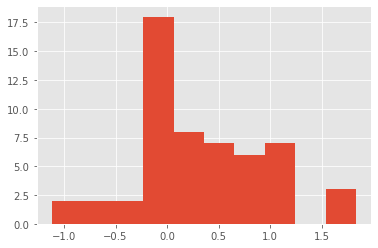

In [504]:
plt.hist(pb_data[11])